# Modelagem

In [1]:
import random
from joblib import dump, load

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

In [3]:
df = pd.read_csv('waitlist_kidney_brazil_prepared.csv', encoding='iso-8859-1')

In [4]:
df.head()

,date_registered,age_registered,dialysis_session_count,sex,underlying_disease,diabetes,chagas,blood_type,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,dr_00,b_00,a_00,anti_hbc,anti_hcv,hbs_ag,event,days_waiting
0,2017-06-29,67,1.0,M,other,True,False,A,0,False,False,0,1,26,44,51,3,7,heterozygous,heterozygous,heterozygous,False,False,False,waiting,392
1,2008-11-03,58,4.0,M,diabetes,False,False,A,0,False,False,0,1,24,18,35,11,0,homozygous,heterozygous,heterozygous,False,False,False,died_waiting,2066
2,2010-07-13,51,2.0,M,hypertension,True,False,O,0,False,False,64,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
3,2011-10-03,52,17.0,M,diabetes,False,False,O,0,False,True,2,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
4,2006-07-05,67,68.0,M,hypertension,True,False,A,0,False,False,0,24,68,14,27,13,15,heterozygous,heterozygous,heterozygous,False,False,False,died_waiting,194


## Limpeza dos dados

In [5]:
df['date_registered'] = pd.to_datetime(df['date_registered'])

In [6]:
df_clean = df#.drop(columns=['date_registered'])

In [7]:
df_clean['event'].value_counts()

event
removed         14356
transplanted    13732
waiting         10933
died_waiting     9132
Name: count, dtype: int64

Removemos os dados com evento `waiting` ou `removed`, porque representam casos em que um transplante não aconteceu.

In [8]:
df_clean = df_clean[df_clean['event'] == 'transplanted']
df_clean['event'].value_counts()

event
transplanted    13732
Name: count, dtype: int64

Removemos a coluna de evento, que passa a ser redundante.

In [9]:
df_clean = df_clean.drop(columns=['event'])

## Engenharia de Features

In [10]:
df_clean['date_transplanted'] = df_clean['date_registered'] + pd.to_timedelta(df_clean['days_waiting'], 'days')

In [11]:
df_clean['date_registered'] = df_clean['date_registered'].astype(int) / (1e9 * 3600 * 24)

In [12]:
df_onehot = pd.get_dummies(df_clean, columns=['sex', 'underlying_disease', 'blood_type', 'dr_00', 'b_00', 'a_00'], drop_first=True)
df_onehot.head()

,date_registered,age_registered,dialysis_session_count,diabetes,chagas,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,anti_hbc,anti_hcv,hbs_ag,days_waiting,date_transplanted,sex_M,underlying_disease_glomerulonephritis,underlying_disease_hypertension,underlying_disease_other,underlying_disease_pyelonephritis,blood_type_AB,blood_type_B,blood_type_O,dr_00_homozygous,b_00_homozygous,a_00_homozygous
12,16310.0,68,14.0,False,False,1,False,False,0,2,3,14,51,1,13,False,False,False,136,2015-01-11,True,False,False,False,False,False,True,False,False,False,False
14,15160.0,62,12.0,True,False,0,False,False,0,2,68,39,40,4,0,False,False,False,268,2012-03-29,True,False,False,True,False,True,False,False,True,False,False
15,12962.0,47,1.0,True,False,0,False,False,0,1,2,40,57,4,4,False,False,False,1345,2009-03-04,True,False,False,True,False,False,False,True,False,False,False
27,13424.0,65,7.0,True,False,0,False,False,0,2,29,44,0,7,11,False,False,False,1283,2010-04-08,True,False,False,True,False,False,False,False,False,True,False
28,15525.0,33,12.0,True,False,0,False,False,0,2,23,8,44,8,15,False,False,False,464,2013-10-11,False,True,False,False,False,False,False,False,False,False,False


In [13]:
df_onehot['idx'] = df_onehot.index

In [14]:
N = df_onehot.shape[0]
N_train = N * 80 // 100

df_onehot.sort_values(by='date_registered', inplace=True, ignore_index=True)
df_onehot, df_test = df_onehot.iloc[:N_train], df_onehot[N_train:]

In [15]:
random.seed(1729)

pairs = set()
while len(pairs) < 200000:
    a = random.randint(1, df_onehot.shape[0] - 1)
    b = random.randint(max(0, a - 1000), a-1)
    ra = df_onehot.iloc[a]
    rb = df_onehot.iloc[b]
    for c in df_onehot.columns:
        if ra[c] < rb[c]:
            pairs.add((a,b))
            break
        if rb[c] < ra[c]:
            pairs.add((b,a))
            break

In [16]:
s = []
for _a, _b in pairs:
    a = df_onehot.iloc[_a]
    b = df_onehot.iloc[_b]
    a.index = a.index + '_a'
    b.index = b.index + '_b'
    s.append(pd.concat((a,b)))
df_cross = pd.DataFrame(s)
df_cross.head()

,date_registered_a,age_registered_a,dialysis_session_count_a,diabetes_a,chagas_a,transfusion_count_a,gestation_a,prior_transplant_a,c_pra_a,hla_a1_a,hla_a2_a,hla_b1_a,hla_b2_a,hla_dr1_a,hla_dr2_a,anti_hbc_a,anti_hcv_a,hbs_ag_a,days_waiting_a,date_transplanted_a,sex_M_a,underlying_disease_glomerulonephritis_a,underlying_disease_hypertension_a,underlying_disease_other_a,underlying_disease_pyelonephritis_a,blood_type_AB_a,blood_type_B_a,blood_type_O_a,dr_00_homozygous_a,b_00_homozygous_a,a_00_homozygous_a,idx_a,date_registered_b,age_registered_b,dialysis_session_count_b,diabetes_b,chagas_b,transfusion_count_b,gestation_b,prior_transplant_b,c_pra_b,hla_a1_b,hla_a2_b,hla_b1_b,hla_b2_b,hla_dr1_b,hla_dr2_b,anti_hbc_b,anti_hcv_b,hbs_ag_b,days_waiting_b,date_transplanted_b,sex_M_b,underlying_disease_glomerulonephritis_b,underlying_disease_hypertension_b,underlying_disease_other_b,underlying_disease_pyelonephritis_b,blood_type_AB_b,blood_type_B_b,blood_type_O_b,dr_00_homozygous_b,b_00_homozygous_b,a_00_homozygous_b,idx_b
0,13449.0,19,4.0,True,False,0,False,False,0,23,66,15,44,12,13,False,False,False,2701,2014-03-21,True,False,False,True,False,False,True,False,False,False,False,24958,13453.0,31,6.0,True,False,1,False,False,0,31,66,40,58,8,14,False,False,False,1054,2009-09-20,True,False,True,False,False,False,False,False,False,False,False,35188
1,13614.0,53,5.0,True,False,0,False,False,0,24,68,27,51,3,10,False,False,False,1472,2011-04-22,False,False,False,True,False,False,False,True,False,False,False,43722,13700.0,36,87.0,True,False,0,False,True,0,31,36,51,53,8,11,False,False,False,1750,2012-04-20,False,False,True,False,False,False,False,True,False,False,False,29660
2,14840.0,54,46.0,True,False,1,False,False,0,3,29,45,52,11,14,True,False,False,374,2011-08-28,True,False,True,False,False,False,False,True,False,False,False,26316,14988.0,45,10.0,True,False,0,False,False,0,2,33,15,53,1,16,False,False,False,480,2012-05-08,True,False,True,False,False,False,True,False,False,False,False,27848
3,13830.0,41,15.0,True,False,0,False,False,0,2,0,39,49,1,8,False,False,False,423,2009-01-09,False,False,False,True,False,False,False,False,False,False,True,41851,13984.0,57,10.0,False,False,0,False,False,0,30,74,42,53,3,11,False,False,False,948,2010-11-19,True,False,False,False,False,False,True,False,False,False,False,168
4,13558.0,37,10.0,True,False,0,False,False,0,3,0,15,49,1,10,False,False,False,1077,2010-01-26,True,False,True,False,False,False,False,False,False,False,True,20527,13721.0,51,26.0,True,False,1,False,False,0,3,32,27,38,13,15,False,False,False,1630,2012-01-12,True,True,False,False,False,False,True,False,False,False,False,27765


In [17]:
df_cross['transplanted_first'] = df_cross['date_transplanted_a'] < df_cross['date_transplanted_b']

In [18]:
df_cross['transplanted_first'].describe()

count     200000
unique         2
top         True
freq      115428
Name: transplanted_first, dtype: object

In [19]:
df_cross_cln = df_cross #.drop(columns=['days_waiting_a', 'days_waiting_b', 'transplant_date_a', 'transplant_date_b'])

In [20]:
target = 'transplanted_first'
_meta = ['idx_a', 'idx_b','days_waiting_a', 'days_waiting_b', 'date_transplanted_a', 'date_transplanted_b']

In [21]:
X, y, meta = df_cross_cln.drop(columns=[target, *_meta]), df_cross_cln[target], df_cross_cln[_meta]

In [22]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, test_size=0.2, random_state=1729)

N = df_cross_cln.shape[0]
N_train = N * 80 // 100

X_train, X_test = X.iloc[:N_train], X.iloc[N_train:]
y_train, y_test = y.iloc[:N_train], y.iloc[N_train:]
meta_train, meta_test = meta.iloc[:N_train], meta.iloc[N_train:]

## Métricas de avaliação

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score

## Modelos

### Plug-in

Modelo de QDA
Não tem hiperparâmetros, mas é o modelo de separação simples plug-in que a gente conhece ¯\\_(ツ)_/¯


In [24]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

/home/guigb/.local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [25]:
y_test_qda = qda.predict(X_test)
(roc_auc_score(y_test, y_test_qda), accuracy_score(y_test, y_test_qda))

(0.577844396793264, 0.6049)

His ass DID NOT learn shit

In [26]:
y_train_qda = qda.predict(X_train)
(roc_auc_score(y_train, y_train_qda), accuracy_score(y_train, y_train_qda))

(0.5904998924799905, 0.61925)

### Risk-minimization


Modelo de SVC Linear.

In [27]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC


In [28]:

linear_svc_params = [
    {
        'linearsvc__penalty': ['l1'],
        'linearsvc__loss': ['squared_hinge'],
        'linearsvc__C': [1,10,100,1000],
    },
    {
        'linearsvc__penalty': ['l2'],
        'linearsvc__loss': ['hinge', 'squared_hinge'],
        'linearsvc__C': [1,10,100,1000],
    },
]

linear_svc_grid = HalvingGridSearchCV(
    make_pipeline(StandardScaler(), LinearSVC(dual='auto', random_state=1729, max_iter=10_000)),
    linear_svc_params,
    verbose=3,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1)
linear_svc_grid.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4444
max_resources_: 40000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 4444
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 3/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1;, score=(train=0.665, test=0.615) total time=   0.5s
[CV 4/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1;, score=(train=0.630, test=0.607) total time=   0.5s
[CV 1/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l2;, score=(train=0.652, test=0.617) total time=   0.1s
[CV 1/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1;, score=(train=0.652, test=0.617) total time=   0.5s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END linearsvc__C=1, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.665, test=0.615) total time=   0.4s
[CV 1/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=l1;, score=(train=0.652, test=0.617) total time=   0.5s
[CV 5/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1;, score=(train=0.655, test=0.610) total time=   0.6s
[CV 2/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l2;, score=(train=0.639, test=0.652) total time=   0.1s
[CV 2/5] END linearsvc__C=1000, linearsvc__loss=squared_hinge, linearsvc__penalty=l1;, score=(train=0.639, test=0.651) total time=   0.5s
[CV 2/5] END linearsvc__C=1, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.634, test=0.642) total time=   0.4s
[CV 4/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=l1;, score=(train=0.630, test=0.607) total time=   0.5s
[CV 4/5] END linearsvc__C=1, linearsvc__loss=hinge, linearsvc__p

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END linearsvc__C=10, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.635, test=0.641) total time=   1.7s
[CV 4/5] END linearsvc__C=10, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.621, test=0.608) total time=   1.8s
[CV 3/5] END linearsvc__C=10, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.665, test=0.614) total time=   1.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END linearsvc__C=10, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.653, test=0.607) total time=   1.9s
[CV 1/5] END linearsvc__C=10, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.648, test=0.616) total time=   2.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.631, test=0.617) total time=   4.4s
[CV 5/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.641, test=0.593) total time=   4.5s
[CV 4/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.613, test=0.597) total time=   4.5s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.651, test=0.615) total time=   4.6s
[CV 2/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.624, test=0.633) total time=   4.7s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.559, test=0.536) total time=   4.9s
[CV 4/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.540, test=0.522) total time=   5.0s
[CV 5/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.555, test=0.522) total time=   5.1s
[CV 1/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.548, test=0.525) total time=   5.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2;, score=(train=0.553, test=0.553) total time=   5.2s
----------
iter: 1
n_candidates: 4
n_resources: 13332
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l2;, score=(train=0.642, test=0.615) total time=   0.4s
[CV 2/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l2;, score=(train=0.636, test=0.617) total time=   0.4s
[CV 4/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l2;, score=(train=0.643, test=0.622) total time=   0.4s
[CV 1/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l2;, score=(train=0.633, test=0.624) total time=   0.4s
[CV 5/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l2;, score=(train=0.634, test=0.628) total time=   0.4s
[CV 1/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=

HalvingGridSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('linearsvc',
                                               LinearSVC(dual='auto',
                                                         max_iter=10000,
                                                         random_state=1729))]),
                    n_jobs=-1,
                    param_grid=[{'linearsvc__C': [1, 10, 100, 1000],
                                 'linearsvc__loss': ['squared_hinge'],
                                 'linearsvc__penalty': ['l1']},
                                {'linearsvc__C': [1, 10, 100, 1000],
                                 'linearsvc__loss': ['hinge', 'squared_hinge'],
                                 'linearsvc__penalty': ['l2']}],
                    scoring='roc_auc', verbose=3)

In [29]:
linear_grid_df = pd.DataFrame(linear_svc_grid.cv_results_)
linear_grid_df.sort_values('mean_test_score', ascending=False)[['mean_fit_time', 'mean_score_time', 'param_linearsvc__C', 'param_linearsvc__loss', 'param_linearsvc__penalty', 'mean_test_score', 'std_test_score']]

,mean_fit_time,mean_score_time,param_linearsvc__C,param_linearsvc__loss,param_linearsvc__penalty,mean_test_score,std_test_score
16,2.345440,0.008695,100,squared_hinge,l1,0.628981,0.003868
17,0.654107,0.011000,1,squared_hinge,l2,0.628981,0.003869
14,0.404301,0.008978,1,squared_hinge,l2,0.621349,0.004704
12,1.370390,0.005886,100,squared_hinge,l1,0.621347,0.004727
15,1.485988,0.004828,1,squared_hinge,l1,0.621345,0.004707
13,1.492851,0.004229,10,squared_hinge,l1,0.621345,0.004730
0,0.598813,0.005964,1,squared_hinge,l1,0.620152,0.016198
5,0.066084,0.006143,1,squared_hinge,l2,0.620102,0.016148
1,0.937091,0.005859,10,squared_hinge,l1,0.620049,0.016049
2,0.535929,0.007483,100,squared_hinge,l1,0.620044,0.016043


In [30]:
y_test_linear_svc = linear_svc_grid.predict(X_test)
(roc_auc_score(y_test, y_test_linear_svc), accuracy_score(y_test, y_test_linear_svc))

(0.5739375497181516, 0.6108)

## Modelos - separação complexa

### Plug-in

K-Nearest Neighbours

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = [
    {
        'knn__n_neighbors': [3,5,11,25],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan', 'hamming'],
    },
]

knn_grid = HalvingGridSearchCV(
    Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    knn_params,
    verbose=3,
    scoring='roc_auc',
    refit=True,
    n_jobs=1)
knn_grid.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4444
max_resources_: 40000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 4444
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=(train=0.843, test=0.546) total time=   0.1s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=(train=0.838, test=0.531) total time=   0.0s
[CV 3/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=(train=0.840, test=0.523) total time=   0.0s
[CV 4/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=(train=0.839, test=0.531) total time=   0.0s
[CV 5/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=(train=0.847, test=0.542) total time=   0.0s
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score

HalvingGridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn', KNeighborsClassifier())]),
                    n_jobs=1,
                    param_grid=[{'knn__metric': ['euclidean', 'manhattan',
                                                 'hamming'],
                                 'knn__n_neighbors': [3, 5, 11, 25],
                                 'knn__weights': ['uniform', 'distance']}],
                    scoring='roc_auc', verbose=3)

In [32]:
knn_grid_df = pd.DataFrame(knn_grid.cv_results_)
knn_grid_df.sort_values('mean_test_score', ascending=False)[['mean_fit_time', 'mean_score_time', 'param_knn__metric', 'param_knn__n_neighbors', 'param_knn__weights', 'mean_test_score', 'std_test_score']]

,mean_fit_time,mean_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,mean_test_score,std_test_score
33,0.036875,5.995157,hamming,5,distance,0.798293,0.002305
34,0.036986,5.985223,hamming,3,distance,0.767478,0.004488
31,0.012103,0.562652,hamming,3,distance,0.700772,0.009877
29,0.011589,0.584453,hamming,5,distance,0.694450,0.011259
32,0.038471,0.895380,manhattan,5,distance,0.688167,0.003380
26,0.011861,0.114986,manhattan,5,distance,0.632087,0.019062
27,0.011892,0.122411,manhattan,11,distance,0.631938,0.017685
30,0.011683,0.134732,manhattan,25,distance,0.630629,0.015598
24,0.011467,0.119229,manhattan,3,distance,0.624885,0.016070
28,0.011736,0.128731,manhattan,25,uniform,0.619147,0.014128


In [33]:
y_test_knn = knn_grid.predict(X_test)
(roc_auc_score(y_test, y_test_knn), accuracy_score(y_test, y_test_knn))

(0.7317498850541544, 0.7439)

In [34]:
dump(knn_grid, 'knn_grid.model')

['knn_grid.model']

### Risk minimization

Modelo de SVC com Kernel não linear

In [37]:
svc_params = [
    {
        'svc__C': [1, 10],
        'svc__kernel': ['poly'],
        'svc__degree': [3, 5],
        'svc__gamma': ['scale', 0.1, 1, 2],
        'svc__coef0': [0, -1, 1],
    },
    {
        'svc__C': [1, 10],
        'svc__kernel': ['rbf', 'sigmoid'],
        'svc__gamma': ['scale', 0.1, 1, 2],
    },
]

svc_grid = HalvingGridSearchCV(
    Pipeline(steps=[('scaler',StandardScaler()), ('svc', SVC(random_state=1729, max_iter=10_000, cache_size=2000))]),
    svc_params,
    verbose=3,
    scoring='roc_auc',
    refit=True,
    n_jobs=1)
svc_grid.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1481
max_resources_: 40000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 1481
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.992, test=0.557) total time=   0.2s
[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.996, test=0.571) total time=   0.0s
[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.994, test=0.619) total time=   0.0s
[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.994, test=0.578) total time=   0.0s
[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.997, test=0.563) total time=   0.0s
[CV 1/5] END svc__C=1, svc__coef0=0

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.619, test=0.519) total time=   0.0s
[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.633, test=0.554) total time=   0.0s
[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.554) total time=   0.0s
[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.521) total time=   0.0s
[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.608) total time=   0.0s
[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.569) total time=   0.0s
[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.580) total time=   0.0s
[CV 1/5] END svc__C=1, svc__coef0=-1,

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.738, test=0.519) total time=   0.0s
[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.739, test=0.491) total time=   0.0s
[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.739, test=0.557) total time=   0.0s
[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.747, test=0.469) total time=   0.0s
[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.726, test=0.556) total time=   0.0s
[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.544) total time=   0.0s
[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.513) total time=   0.0s
[CV 3/5] END svc__C=1, svc__coe

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.634, test=0.492) total time=   0.0s
[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.633, test=0.534) total time=   0.0s
[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.554) total time=   0.0s
[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.521) total time=   0.0s
[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.608) total time=   0.0s
[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.569) total time=   0.0s
[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.580) total time=   0.0s
[CV 1/5] END svc__C=10, svc__c

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.732, test=0.488) total time=   0.0s
[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.740, test=0.565) total time=   0.0s
[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.731, test=0.470) total time=   0.0s
[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly;, score=(train=0.726, test=0.557) total time=   0.0s
[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.544) total time=   0.0s
[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.513) total time=   0.0s
[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.593) total time=   0.0s
[CV 4/5] END svc__C=10, sv

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.631) total time=   0.1s
[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.591) total time=   0.1s
[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.552) total time=   0.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.550) total time=   0.0s
[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.535) total time=   0.0s
[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.613) total time=   0.0s
[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.594) total time=   0.0s
[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.553) total time=   0.0s
[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.568) total time=   0.0s
[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.521) total time=   0.0s
[CV 3/5] END svc__C=10, svc__co

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid;, score=(train=0.285, test=0.603) total time=   0.1s
[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid;, score=(train=0.313, test=0.456) total time=   0.1s
[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid;, score=(train=0.273, test=0.531) total time=   0.1s
[CV 1/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.569) total time=   0.1s
[CV 2/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.547) total time=   0.1s
[CV 3/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.592) total time=   0.1s
[CV 4/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.554) total time=   0.1s
[CV 5/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.575) total time=   0.0s
[CV 1/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid;, score=(train=0.352, test=0.506) total time=   0.

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.564) total time=   0.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.569) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.576) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.544) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.591) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.567) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.566) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.566) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.538) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.582) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.567) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.566) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.566) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.538) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.582) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.546) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.540) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.584) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.558) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.546) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.540) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly;, score=(train=1.000, test=0.584) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.546) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.540) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.584) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.546) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.540) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.584) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.546) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.540) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.584) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.546) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.559) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.540) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.584) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.996, test=0.576) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.998, test=0.583) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.996, test=0.583) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.997, test=0.562) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.997, test=0.584) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.561) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.548) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.561) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.539) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.585) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.561) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.548) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.561) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.539) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly;, score=(train=1.000, test=0.585) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.563) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.550) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.563) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.539) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.586) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.563) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.550) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.563) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.539) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly;, score=(train=1.000, test=0.586) total time=   0.3s
[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.569) total time=   0.3s
[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.545) total time=   0.3s
[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.575) total time=   0.3s
[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.563) total time=   0.3s
[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.606) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.574) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.573) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.581) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.547) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.599) total time=   0.3s
[CV 1/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.587) total time=   0.4s
[CV 2/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.580) total time=   0.4s
[CV 3/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.600) total time=   0.4s
[CV 4/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.545) total time=   0.4s
[CV 5/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.608) total time=   0.5s
[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.975, test=0.573) total time=   0.3s
[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.968, test=0.549) total time=   0.3s
[CV 3/5] END svc__C=1, svc__coef0=0, svc

/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.575) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.551) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.569) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.998, test=0.550) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.602) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.996, test=0.586) total time=   0.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.997, test=0.574) total time=   0.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.995, test=0.612) total time=   0.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.996, test=0.559) total time=   0.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.998, test=0.610) total time=   0.4s
[CV 1/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.921, test=0.596) total time=   0.4s
[CV 2/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.903, test=0.574) total time=   0.4s
[CV 3/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.911, test=0.625) total time=   0.4s
[CV 4/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.898, test=0.593) total time=   0.4s
[CV 5/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.905, test=0.630) total time=   0.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.944, test=0.588) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.940, test=0.566) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.947, test=0.612) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.945, test=0.575) total time=   0.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.946, test=0.608) total time=   0.3s
----------
iter: 2
n_candidates: 8
n_resources: 13329
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.604) total time=   2.7s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.574) total time=   2.6s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.597) total time=   2.6s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.589) total time=   2.6s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.596) total time=   2.6s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.917, test=0.613) total time=   3.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.919, test=0.580) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.917, test=0.612) total time=   3.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.917, test=0.593) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.917, test=0.596) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.982, test=0.603) total time=   2.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.976, test=0.567) total time=   2.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.977, test=0.585) total time=   2.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.976, test=0.593) total time=   2.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly;, score=(train=0.980, test=0.584) total time=   2.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.751, test=0.567) total time=   1.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.784, test=0.542) total time=   1.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.785, test=0.557) total time=   1.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.776, test=0.572) total time=   1.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.771, test=0.544) total time=   1.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.616) total time=   4.2s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.585) total time=   4.2s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.607) total time=   4.2s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.599) total time=   4.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=(train=1.000, test=0.607) total time=   4.1s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.980, test=0.631) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.982, test=0.593) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.981, test=0.616) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.984, test=0.606) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.980, test=0.617) total time=   3.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.859, test=0.629) total time=   2.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.860, test=0.596) total time=   2.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.866, test=0.623) total time=   2.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.859, test=0.609) total time=   2.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.857, test=0.623) total time=   2.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.869, test=0.634) total time=   3.9s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.869, test=0.598) total time=   3.9s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.862, test=0.636) total time=   3.9s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.870, test=0.631) total time=   3.9s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.866, test=0.631) total time=   3.8s
----------
iter: 3
n_candidates: 3
n_resources: 39987
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.762, test=0.584) total time=  17.2s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.792, test=0.584) total time=  15.9s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.776, test=0.572) total time=  15.3s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.783, test=0.593) total time=  15.5s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.781, test=0.576) total time=  15.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.626, test=0.566) total time=  12.8s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.617, test=0.556) total time=  13.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.626, test=0.564) total time=  12.6s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.629, test=0.563) total time=  12.5s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.636, test=0.560) total time=  13.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.767, test=0.637) total time=  23.7s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.781, test=0.633) total time=  23.4s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.767, test=0.636) total time=  24.7s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.778, test=0.635) total time=  24.0s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.777, test=0.631) total time=  23.7s


/home/guigb/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


HalvingGridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svc',
                                               SVC(cache_size=2000,
                                                   max_iter=10000,
                                                   random_state=1729))]),
                    n_jobs=1,
                    param_grid=[{'svc__C': [1, 10], 'svc__coef0': [0, -1, 1],
                                 'svc__degree': [3, 5],
                                 'svc__gamma': ['scale', 0.1, 1, 2],
                                 'svc__kernel': ['poly']},
                                {'svc__C': [1, 10],
                                 'svc__gamma': ['scale', 0.1, 1, 2],
                                 'svc__kernel': ['rbf', 'sigmoid']}],
                    refit='roc_auc', scoring='roc_auc', verbose=4)

In [39]:
svc_grid_df = pd.DataFrame(svc_grid.cv_results_)
svc_grid_df.sort_values('mean_test_score', ascending=False)[['mean_fit_time', 'mean_score_time', 'param_svc__C', 'param_svc__kernel', 'param_svc__degree', 'param_svc__gamma', 'param_svc__coef0', 'mean_test_score', 'std_test_score']]

,mean_fit_time,mean_score_time,param_svc__C,param_svc__kernel,param_svc__degree,param_svc__gamma,param_svc__coef0,mean_test_score,std_test_score
96,18.292804,5.607623,1,rbf,NaN,scale,NaN,0.634268,0.002076
93,3.065523,0.809643,1,rbf,NaN,scale,NaN,0.626097,0.014080
92,2.118250,0.294197,1,poly,3,scale,1,0.616236,0.011990
91,2.211192,0.769076,10,rbf,NaN,scale,NaN,0.612662,0.012683
84,0.287028,0.097163,1,rbf,NaN,scale,NaN,0.603588,0.021176
90,3.199683,0.966518,1,rbf,NaN,0.1,NaN,0.602853,0.010565
87,2.716950,0.327062,1,poly,3,scale,0,0.598732,0.012288
86,2.263081,0.377658,10,poly,5,scale,0,0.592111,0.010182
85,0.284258,0.036106,1,poly,3,scale,1,0.589607,0.017931
16,0.042063,0.007360,1,poly,3,scale,1,0.589307,0.030650


In [40]:
y_test_svc = svc_grid.predict(X_test)
(roc_auc_score(y_test, y_test_svc), accuracy_score(y_test, y_test_svc))

(0.5694363507607965, 0.6377)

In [31]:
dump(svc_grid, 'svc_grid.model')

## Risco bayesiano

In [30]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [27]:
forest_params = [
    {
        'pca': ['passthrough'],
        'forest__n_estimators': [500, 1000, 1500],
        'forest__min_samples_split': [2, 10],
        'forest__max_features': ['sqrt', 'log2'],
    },
    {
        'pca': [PCA(random_state=1729)],
        'pca__n_components': [10, 30],
        'forest__n_estimators': [1000,1500],
        'forest__min_samples_split': [2, 10],
        'forest__max_features': ['sqrt', 'log2'],
    },
]


forest_grid = HalvingGridSearchCV(
    Pipeline(steps=[('pca', PCA(random_state=1729)), ('forest', RandomForestClassifier(random_state=1729, n_jobs=-1))]),
    forest_params,
    verbose=4,
    scoring='roc_auc',
    refit=True,
    n_jobs=1)
forest_grid.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1481
max_resources_: 40000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 28
n_resources: 1481
Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough;, score=(train=1.000, test=0.662) total time=   1.1s
[CV 2/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough;, score=(train=1.000, test=0.675) total time=   1.1s
[CV 3/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough;, score=(train=1.000, test=0.685) total time=   1.0s
[CV 4/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough;, score=(train=1.000, test=0.671) total time=   1.0s
[CV 5/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_

HalvingGridSearchCV(estimator=Pipeline(steps=[('pca', PCA(random_state=1729)),
                                              ('forest',
                                               RandomForestClassifier(n_jobs=-1,
                                                                      random_state=1729))]),
                    n_jobs=1,
                    param_grid=[{'forest__max_features': ['sqrt', 'log2'],
                                 'forest__min_samples_split': [2, 10],
                                 'forest__n_estimators': [500, 1000, 1500],
                                 'pca': ['passthrough']},
                                {'forest__max_features': ['sqrt', 'log2'],
                                 'forest__min_samples_split': [2, 10],
                                 'forest__n_estimators': [1000, 1500],
                                 'pca': [PCA(random_state=1729)],
                                 'pca__n_components': [10, 30]}],
                    scoring='roc_auc', verbose=4)

In [28]:
forest_grid_df = pd.DataFrame(forest_grid.cv_results_)
forest_grid_df.sort_values('mean_test_score', ascending=False)[['mean_fit_time', 'mean_score_time', 'param_pca__n_components', 'param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__max_features', 'mean_test_score', 'std_test_score']]

,mean_fit_time,mean_score_time,param_pca__n_components,param_forest__n_estimators,param_forest__min_samples_split,param_forest__max_features,mean_test_score,std_test_score
43,6.400563,0.493930,NaN,1500,2,sqrt,0.782919,0.001900
42,5.801655,0.484686,NaN,1500,2,log2,0.779450,0.001714
41,4.029474,0.425384,NaN,1500,2,sqrt,0.717765,0.008806
40,3.892315,0.445826,NaN,1500,2,log2,0.717091,0.008464
39,2.730756,0.298774,NaN,1000,2,sqrt,0.716434,0.009236
38,1.358066,0.154230,NaN,500,2,sqrt,0.714895,0.010768
31,3.143049,0.425715,NaN,1500,2,sqrt,0.679363,0.010691
28,2.998700,0.415756,NaN,1500,2,log2,0.678665,0.009431
30,2.045220,0.292081,NaN,1000,2,sqrt,0.678582,0.010141
29,0.997731,0.140392,NaN,500,2,sqrt,0.678080,0.012981


In [31]:
forest_grid = RandomForestClassifier(
    n_estimators=1500,
    min_samples_split=2,
    max_features='sqrt',
    random_state=1729,
    n_jobs=-1
)
forest_grid.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=1729)

In [78]:
y_test_forest = forest_grid.predict_proba(X_test)[:,1]
y_test_forest_05 = y_test_forest > 0.5
(roc_auc_score(y_test, y_test_forest_05), accuracy_score(y_test, y_test_forest_05))

(0.7559540584585669, 0.774675)

In [33]:
dump(forest_grid, 'forest_grid.model')

['forest_grid.model']

In [24]:
forest_grid = load('forest_grid.model')

#### Risco bayesiano

Cálculo da razão de verossimilhança. Aqui fazemos a mesma assumpção do notebook que $\mathcal{L}(x|Y=y) = \hat p (y|x)$

In [27]:
L_y_test_forest = y_test_forest / (1 - y_test_forest)
L_y_test_forest_1 = (L_y_test_forest > 1)

In [28]:
(roc_auc_score(y_test, L_y_test_forest_1), accuracy_score(y_test, L_y_test_forest_1))

(0.7559540584585669, 0.774675)

Disitribuição das classes no dado original:

In [29]:
y_test.mean()

0.5771

Risco padrão: $\eta = 1$

No nosso caso, o problema é inerentemente simétrico. Como existem poucos pacientes transplantados no mesmo dia, podemos desconsiderá-los. Então, dados dois pacientes quaisquer $p$ e $q$, existe uma ordem absoluta entre $p$ e $q$ e a chance de aleatoriamente escolher $(p, q)$ é a mesma de escolher $(q, p)$. Logo, o problema é balanceado.

Também podemos observar que um falso positivo para $(p, q)$ é equivalente a um falso negativo para $(q, p)$. Logo, os custos para falsos negativos e positivos devem serem os mesmos e, portanto, o limite bayesiano é igual ao risco padrão.

Abaixo, tentamos encontrar o limite que aproxima a distribuição de classes entre o dado original e o dado previsto

In [76]:
i = 0
l, r = 0, 2
while r - l > 1e-12:
    m = (l + r) / 2
    if (L_y_test_forest > m).mean() <= y_test.mean():
        r = m
    else:
        l = m
    i += 1
print(f"threshold={m} rate={(L_y_test_forest > m).mean()}")

threshold=1.1865889212831462 rate=0.5764


### Concordância

In [39]:
def qsort(data, compare_many_one):
    if len(data) <= 1:
        return data
    else:
        p = random.choice(range(len(data)))
        pivot = data[p]
        cmp = compare_many_one(data, pivot)
        lt, gt = [], []
        for i in range(len(data)):
            if i == p:
                continue
            if cmp[i]:
                lt.append(data[i])
            else:
                gt.append(data[i])
        data = qsort(lt, compare_many_one)
        data.append(pivot)
        data.extend(qsort(gt, compare_many_one))
        return data

In [45]:
X_ord_test = df_test.drop(columns=['date_transplanted', 'days_waiting', 'idx'])

def compare_entries(xs, y):
    pivot = X_ord_test.loc[y]
    pivot.index = pivot.index + '_b'
    data = X_ord_test.loc[xs].rename(columns = lambda col: f"{col}_a")
    s = []
    for i in data.index:
        s.append(pd.concat((data.loc[i], pivot)))
    return forest_grid.predict_proba(pd.DataFrame(s))[:,1] >= 0.5

order = qsort(X_ord_test.index, compare_entries)
df_test.loc[order].head()

,date_registered,age_registered,dialysis_session_count,diabetes,chagas,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,anti_hbc,anti_hcv,hbs_ag,days_waiting,date_transplanted,sex_M,underlying_disease_glomerulonephritis,underlying_disease_hypertension,underlying_disease_other,underlying_disease_pyelonephritis,blood_type_AB,blood_type_B,blood_type_O,dr_00_homozygous,b_00_homozygous,a_00_homozygous,idx
12405,16889.0,39,51.0,False,False,1,False,False,0,2,3,15,0,1,11,True,False,False,319,2017-02-11,True,False,False,False,False,False,False,False,False,True,False,41026
12836,17029.0,12,22.0,True,False,1,False,False,0,2,23,40,44,4,9,False,False,False,284,2017-05-27,False,True,False,False,False,False,False,True,False,False,False,32477
13411,17312.0,17,9.0,True,False,1,False,False,0,2,33,7,15,1,1,False,False,False,98,2017-09-01,False,False,False,True,False,False,False,False,False,False,False,17954
12820,17021.0,16,9.0,True,False,1,False,False,0,24,30,8,35,1,13,False,False,False,23,2016-08-31,True,True,False,False,False,False,False,False,False,False,False,38483
11702,16633.0,16,8.0,True,False,0,False,False,0,23,66,14,51,1,11,False,False,False,189,2016-01-22,False,False,False,True,False,False,False,False,False,False,False,26210


In [90]:
!pip3 install lifelines

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 13.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 7.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1a6c7dd403139f72f1823749d7a904758932aecbba3ade0b04f3165d3d0de1fe
  Stored in directory: /home/guigb/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb82

In [50]:
from lifelines.utils import concordance_index

order_inv = pd.Series(index = df_test.index)
for i, j in enumerate(order):
    order_inv.loc[j] = i

concordance_index(df_test['date_transplanted'].astype(int), order_inv)

0.5332455388149704

### Calibração

In [42]:
# from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier(n_estimators=200, max_features='log2')
# forest.fit(X_train, y_train)
y_test_forest_2 = forest_grid.predict_proba(X_test)[:,1]

In [43]:
import matplotlib.pyplot as plt

In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(y_test_forest_2.reshape(-1,1), y_test)

LogisticRegression()

Brier score original 0.19100336631111112
Brier score pós-calibração 0.17752834921293678


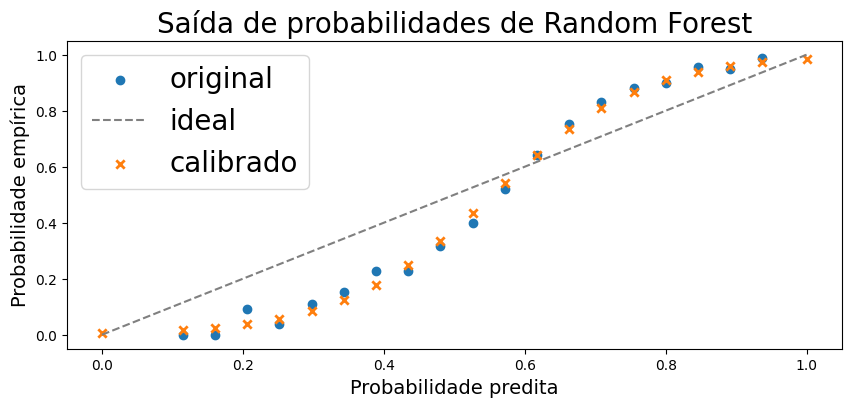

In [45]:
from sklearn.metrics import brier_score_loss
pred_probs_space = np.linspace(y_test_forest_2.min(), y_test_forest_2.max(), 20)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(np.mean(y_test[(y_test_forest_2 > pred_probs_space[i]) & (y_test_forest_2 < pred_probs_space[i+1])]))
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)


calibrated_probs = lr.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
print('Brier score original', brier_score_loss(y_test, y_test_forest_2.reshape(-1,1)))
print('Brier score pós-calibração', brier_score_loss(y_test, lr.predict_proba(y_test_forest_2.reshape(-1,1))[:,1]))

plt.figure(figsize=(10,4))
plt.scatter(pred_probs_midpoints, empirical_probs, marker='o')
plt.title(f"Saída de probabilidades de Random Forest", fontsize=20)
plt.xlabel('Probabilidade predita', fontsize=14)
plt.ylabel('Probabilidade empírica', fontsize=14)

plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.scatter([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='x')

plt.legend(['original', 'ideal', 'calibrado'], fontsize=20)
plt.show()